In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(X):
    return 3*X**2 -4*X + 5

In [3]:
f(3.0)

20.0

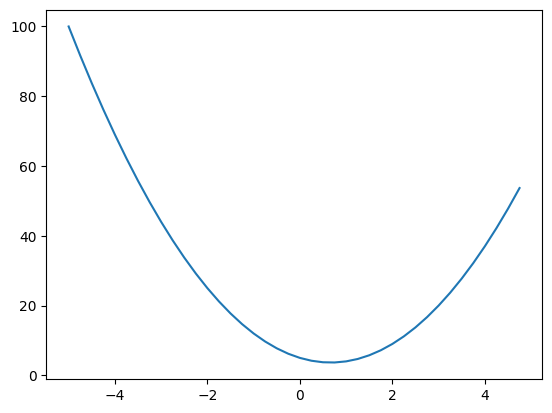

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)

plt.plot(xs, ys)

In [49]:
class Value:
    def __init__(self, data, _children = (), _op ='', label = ''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value data = {self.data}"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)     # other is other if it is instance of Value and if not hten we make it a instance of Value
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
        
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int and float pow for now"
        out = Value(self.data ** other, (self, ), f'**{other}')

        def _backward():
            self.grad += (other * self.data ** (other - 1)) * out.grad
        out._backward = _backward
        return out
        
    def __rmul__(self, other): # other * self
        return self * other
    def __radd__(self, other):
        return self + other

    def __truediv__(self, other):     #divide
        return self * (other ** -1)

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)
        
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) -1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1- t**2) * out.grad
        out._backward = _backward
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out
        
    def backward(self):

        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0

        for node in reversed(topo):
            node._backward()

In [6]:
a = Value(2, label = 'a')
b = Value(1, label = 'b')
a/b

Value data = 2.0

In [7]:
from graphviz import Digraph

def trace(root):
    # Build a set of all nodes and edges in a graph
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  # Left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # fixed the incorrect use of curly braces (should be parentheses in % formatting)
        dot.node(name=uid, 
                 label=f"{{ {n.label} | data {n.data:.4f} | grad {n.grad:.4f} }}", 
                 shape='record')

        if n._op:
            op_uid = uid + n._op
            dot.node(name=op_uid, label=n._op)
            dot.edge(op_uid, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot


In [8]:
#input x1, x2
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')

#weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

#bias
b = Value(6.881373587047829023, label = 'b')

#x1w1, x2w2
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

#x1w1 + x2w2 + b
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

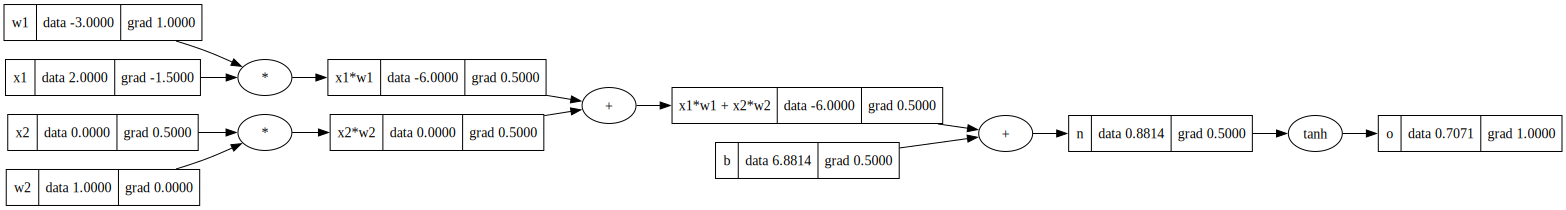

In [9]:
draw_dot(o)

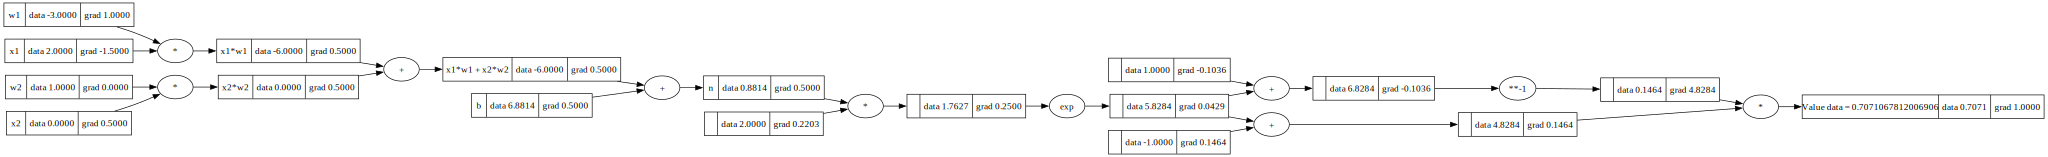

In [10]:
#input x1, x2
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')

#weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

#bias
b = Value(6.881373587047829023, label = 'b')

#x1w1, x2w2
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

#x1w1 + x2w2 + b
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
e = (2 * n).exp()
o = (e - 1)/(e+1)

o.label = o
o.backward()
draw_dot(o)

In [16]:
import torch
import random

In [62]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
    #w*x + b
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    def parameters(self):
        return self.w + [self.b]
    
class Layer:

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs

    def parameters(self):
        # params = []
        # for neuron in self.neurons:
        #     ps = neuron.paramenters()
        #     params.extend(ps)
        # return params
        return [p for neuron in self.neurons for p in neuron.parameters()]
class MLP:

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

[Value data = 0.5200186582588764]

In [56]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]



[Value data = 0.01491292880444002,
 Value data = -0.0730494253156215,
 Value data = 0.313946592573644,
 Value data = -0.16531007717181384]

In [97]:
ypred = [n(x)[0] for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value data = 3.7632256979248173

In [79]:
ypred = [n(x)[0] for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value data = 4.6451127205389415

In [95]:
loss.backward()

In [96]:
for p in n.parameters():
    p.data += -0.01 * p.grad

In [219]:
for k in range(100):
    #forward pass
    ypred = [n(x)[0] for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

    #backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
    for p in n.parameters():
        p.data += -0.01 * p.grad
        
    # print(k, loss.data)
